In this post, I propose and implement a method of quality ranking scotches that attempts to remove the preferences of specific tasters from influencing the ultimate results as much as possible. First, I define the ranking method, then I implement it, generating a list of the "best" scotches.

#### Method

To rank scotches, one first needs to specify a set of criteria by which to judge every scotch. Once those criteria are defined, the "best" scotches will be those that rank most highly according to the criteria. I propose complexity and balance as the essential criteria to judge scotch. [source]

How are complexity and balance defined? Imagine the ideal or perfect scotch. According to one theory, that scotch would possess all the possible flavors that a scotch could possess. For example, it would be fruity, smoky, peaty, et cetera. A scotch that possesses a large number of these possible flavors is called complex. Additionally in the ideal scotch, each of the flavors would be distinct, not muddled, and discernible. No small group of flavors would dominate all of the others. If a scotch possesses this quality, it is called balanced. So not only does the ideal scotch possess a large number of flavors, it possess them in right proportion to one another so that all are identifiable by a skilled taster. 

The more complex and balanced a scotch is, the more closely it approximates the ideal scotch and the higher it ranks according to this method.

#### Implementation

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
sns.set_style('white')
sns.set_context("notebook", font_scale=1.2)

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [2]:
file_name = 'whiskies_w_coords.csv'
top_scotches_to_map = 7

In [3]:
data = pd.read_csv(file_name)
to_rename = {
    'whiskies.Latitude':'FinalLat',
    'whiskies.Longitude':'FinalLong'
}
data = data.rename(columns=to_rename)
data = data.set_index('Distillery')
data = data.loc[:,'Body':]

In [4]:
flavors = data.loc[:, 'Body':'Floral']
location = data.loc[:, 'FinalLat':]

How can one actually implement this method of ranking scotches? Before I answer that question, I will describe the data that are used as inputs to this method. The data, which can be sourced from this site [source], describe the range and intensity of flavors that are present in a given scotch. The data set has 12 columns; each one corresponding to a different flavor that may be present in scotch, for example sweetness, smoky, honey, or floral. Each row of the data set corresponds to a distillery, and each distillery is represented by a single record. You may ask, how can each distillery be represented by single record? The reason is that each distillery is rated based upon its most popular product, not its full range of products. Each distillery is rated from 0 to 4 in each flavor category; 0 being low/no intensity, 4 being high intensity. The 0 to 4 ratings were assigned initially by a small panel of experts, then passed around to various other members of the whisky industry for feedback. See [source] for more info on the data and the details of the original analysis, including clustering and principal component analysis, performed with this data

In [5]:
flavors.head()

,Body,Sweetness,Smoky,Medicinal,Tobacco,Honey,Spicy,Winey,Nutty,Malty,Fruity,Floral
Distillery,,,,,,,,,,,,
Aberfeldy,2,2,2,0,0,2,1,2,2,2,2,2
Aberlour,3,3,1,0,0,4,3,2,2,3,3,2
AnCnoc,1,3,2,0,0,2,0,0,2,2,3,2
Ardbeg,4,1,4,4,0,0,2,0,1,2,1,0
Ardmore,2,2,2,0,0,1,1,1,2,3,1,1


In [6]:
location.head()

,FinalLat,FinalLong
Distillery,,
Aberfeldy,-3.850199,56.625191
Aberlour,-3.229644,57.467395
AnCnoc,-2.785295,57.441751
Ardbeg,-6.108503,55.640607
Ardmore,-2.743629,57.350557


Using the data described above, one can calculate quantitatve measures of both complexity and balance and then rank scotches based upon these measures. First, complexity is captured by counting the number of flavor categories with a non-zero intensity rating; this count is referrred to as the "complexity score." Second, balance is captured by calculating the mean flavor intensity divided by standard deviation of all flavor intensities for a given distillery; this value is referred to the "balance score." The postive correlation between mean intensity and the balance score is meant to express the idea that a more intense flavor overall is preferable to a less intense one. The negative correlation between standard deviation and the balance score is meant to express the idea that a scotch with similar ratings across flavor categories is preferable to one with more disparate flavor intensities. In summary, "balance" increases as mean flavor intensity increases and decreases as the standard deviation of flavor intensities increases.

Calculate the "complexity" score.

In [7]:
flavors_count = flavors != 0
ratings = pd.DataFrame()
ratings['Complexity'] = flavors_count.sum(axis=1)

Calculate the "balance" score.

In [8]:
ratings['Mean'] = flavors.mean(axis=1)
ratings['Std'] = flavors.std(axis=1)
ratings['Balance'] = ratings['Mean']/ratings['Std']

In [9]:
ratings.head()

,Complexity,Mean,Std,Balance
Distillery,,,,
Aberfeldy,10,1.583333,0.792961,1.996734
Aberlour,10,2.166667,1.267304,1.709665
AnCnoc,8,1.416667,1.164500,1.216545
Ardbeg,8,1.583333,1.621354,0.976550
Ardmore,10,1.333333,0.887625,1.502135


The complexity and balance scores must then be used in such a way so as to create a single ranking of all scotches. Without combining the two scores into a single metric, there are two ways to use these two scores to create a single ranking: either sort by complexity first, then balance; or by balance first, then complexity. There is a large degree of overlap between the resulting two rankings; seven of the top ten whiskies are the same irrelevant of which order the sorting is performed. These seven scotches and their respective scores are listed below.

In [16]:
ratings = ratings.reset_index()

by_count_score = ratings.sort_values(by=['Complexity', 'Balance'], ascending=False)
by_count_score = by_count_score.reset_index(drop=True)
by_count_score['ComplexityThenBalanceRank'] = by_count_score.reset_index()['index'] + 1

by_score_count = ratings.sort_values(by=['Balance', 'Complexity'], ascending=False)
by_score_count = by_score_count.reset_index(drop=True)
by_score_count['BalanceThenComplexityRank'] = by_score_count.reset_index()['index'] + 1

In [17]:
ratings_table = ratings.merge(by_count_score[['Distillery', 'ComplexityThenBalanceRank']], how='inner', on='Distillery')
ratings_table = ratings_table.merge(by_score_count[['Distillery', 'BalanceThenComplexityRank']], how='inner', on='Distillery')
ratings_table.to_csv('top_scotch_table.csv', index=False)

In [18]:
ratings['Category'] = ''

best_scotches_intersection = set(by_score_count['Distillery'].head(10)).intersection(by_count_score['Distillery'].head(10))
best_scotches_union = set(by_score_count['Distillery'].head(10)).union(by_count_score['Distillery'].head(10))
ratings.loc[ratings.loc[:, 'Distillery'].isin(best_scotches_intersection), 'Category'] = 'Best in Both'
top_in_one_mask = ratings.loc[:, 'Distillery'].isin(best_scotches_union) & ~ratings.loc[:, 'Distillery'].isin(best_scotches_intersection)
ratings.loc[top_in_one_mask, 'Category'] = 'Best in One'

popular_scotches = ['Macallan', 'Glenlivet', 'Glenfiddich', 'Glenmorangie', 'Laphroig']
ratings.loc[ratings.loc[:, 'Distillery'].isin(popular_scotches), 'Category'] = 'Popular'

In [19]:
ratings[ratings.loc[:,'Category'] == 'Popular']

,index,Distillery,Complexity,Mean,Std,Balance,Category
45,45,Glenfiddich,6,0.916667,1.083625,0.845926,Popular
48,48,Glenlivet,10,1.666667,0.984732,1.692508,Popular
50,50,Glenmorangie,10,1.333333,0.778499,1.712698,Popular
58,58,Laphroig,8,1.500000,1.623688,0.923823,Popular
62,62,Macallan,10,1.916667,1.378954,1.389942,Popular


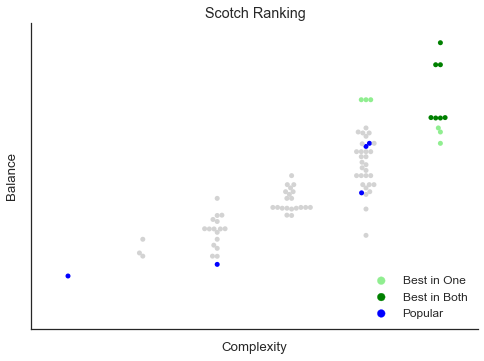

In [20]:
hue_mapping = {
    '': 'lightgrey',
    'Best in One': 'lightgreen',
    'Best in Both': 'green',
    'Popular': 'blue'
}
g = sns.swarmplot(y='Balance', x='Complexity', hue='Category', palette=hue_mapping, data=ratings)
g.set(xticklabels=[], yticklabels=[], title='Scotch Ranking')
sns.despine(bottom=False, left=False)
plt.legend(loc='lower right')

One question that comes to mind is, are the top scotches generally produced in a specific geographical area of Scotland? The graph below plots the locations of the distilleries that produce the top five scotches. Interestingly, two of the top five scotches (Bruichladdich and Bowmore) are produced by distilleries located on the island of Islay, which is generally known for very unbalanced, smokey scotches. Also, three of the top five scotches are produced by distilleries located on islands off the coast of Scotland. Is there some reason to believe that a higher quality is more likely to be produced at a distillery located on an island?

In [25]:
map_data = ratings[ratings['Category'] == 'Best in Both'].merge(location, how='left', left_on='Distillery', right_index=True)

In [23]:
map_data.reset_index().loc[:,['FinalLat','FinalLong','Distillery']].to_csv('top_scotches_map.csv')

This method of ranking the quality of scotches, though not without its weaknesses, has some important strengths. Among them are its simplicity and the fact that it removes any variation in ratings due to individual taster preferences. As such, it is an interesting complement to more traditional rating methods.

What is your opinion of this ranking method? Leave your thoughts in the comments. 

references: 
1. "The Ideal Scotch" by Thom Brooks in "Whiskey and Philosophy"
2. http://whiskyanalysis.com/index.php/methodology-introduction/methodology-flavour-comparison/
3. https://www.mathstat.strath.ac.uk/outreach/nessie/nessie_whisky.html- 